# 1. Static Repulication

In [ ]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt


# European option payoff function
def european_option_payoff(S, K, option_type="call"):
    if option_type == "call":
        return np.maximum(S - K, 0)
    elif option_type == "put":
        return np.maximum(K - S, 0)

# Digital option payoff function
def digital_option_payoff(S, K, option_type="call"):
    if option_type == "call":
        return np.where(S >= K, 1, 0)
    elif option_type == "put":
        return np.where(S <= K, 1, 0)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")

# Knock-out option payoff function
def knock_out_payoff(S, K, barrier, option_type="call"):
    if option_type == "call":
        return np.where(S < barrier, np.maximum(S - K, 0), 0)
    elif option_type == "put":
        return np.where(S > barrier, np.maximum(K - S, 0), 0)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")


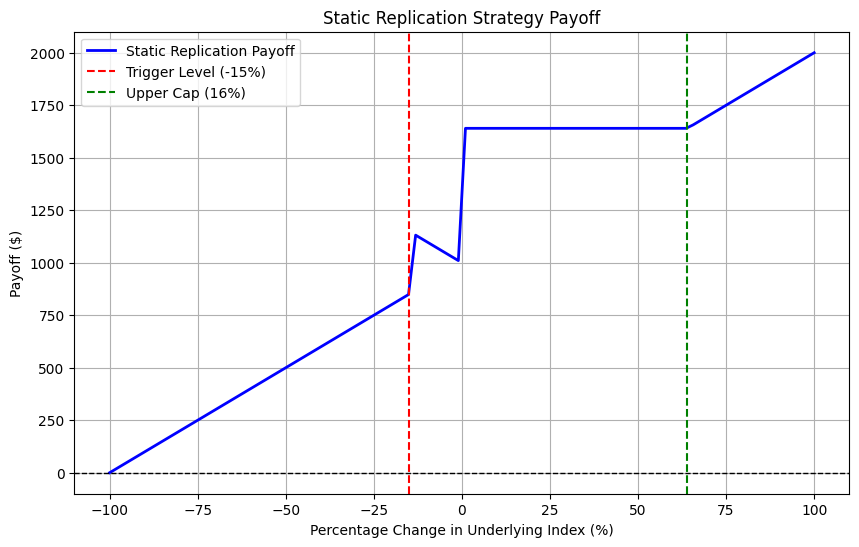

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 0.01-10$
S0 = 4833.53
T = 1
r = 0.03
sigma = 0.2

index_changes = np.linspace(-1, 1, 100)
S_T = S0 * (1 + index_changes)

# [-100,-15]
put_payoff_1 = european_option_payoff(S_T, 0.85 * S0, option_type="put")
digital_put_payoff_1 = digital_option_payoff(S_T, 0.85 * S0, option_type="put")
#[-15,0]
digital_call_payoff_2 = digital_option_payoff(S_T, 0.85*S0, option_type="call")
call_payoff_1 = european_option_payoff(S_T, 0.85 * S0, option_type="call")
call_payoff_2 = european_option_payoff(S_T, S0, option_type="call")

#[0,64]
digital_call_payoff_3 = digital_option_payoff(S_T, S0, option_type="call")
#[64,]
call_payoff_3 = european_option_payoff(S_T, 1.64 * S0, option_type="call")


replication_payoff = 1000/S0 *(-put_payoff_1 -digital_put_payoff_1*0.15*S0 - call_payoff_1 + digital_call_payoff_2*0.15*S0 + call_payoff_2 + digital_call_payoff_3*0.64*S0 + call_payoff_3 + S0)

# 绘制收益曲线
plt.figure(figsize=(10, 6))
plt.plot(index_changes * 100, replication_payoff, label="Static Replication Payoff", linewidth=2, color='blue')
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.axvline(-15, color="red", linestyle="--", label="Trigger Level (-15%)")
plt.axvline(64, color="green", linestyle="--", label="Upper Cap (16%)")

plt.xlabel("Percentage Change in Underlying Index (%)")
plt.ylabel("Payoff ($)")
plt.title("Static Replication Strategy Payoff")
plt.legend()
plt.grid()
plt.show()


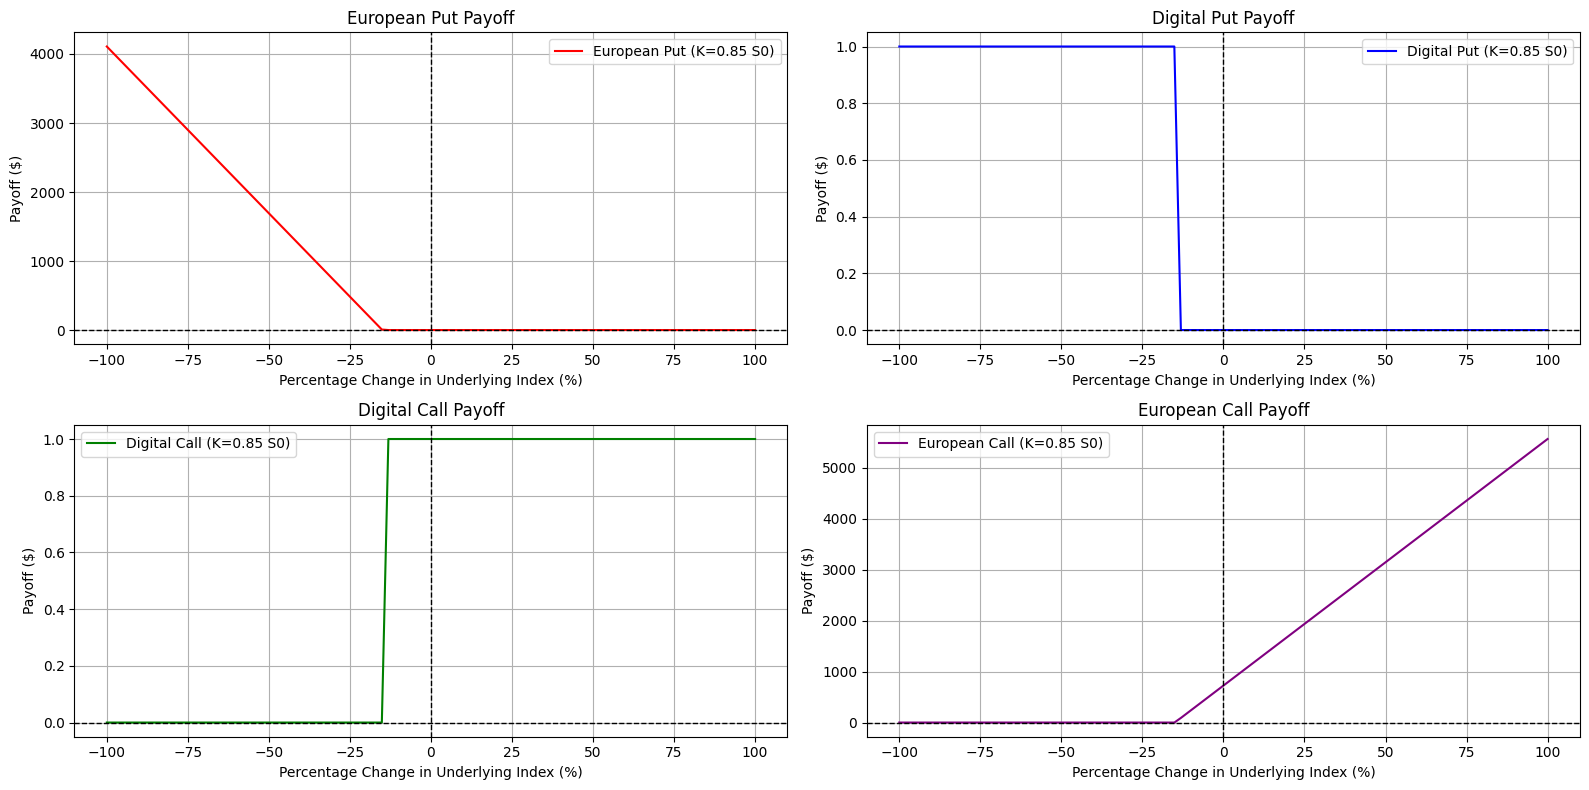

In [ ]:
# 创建图像并绘制每个期权的支付
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.flatten()

# 绘制 [-100, -15] 区间
axes[0].plot(index_changes * 100, put_payoff_1, label="European Put (K=0.85 S0)", color='red')
axes[0].set_title("European Put Payoff")

axes[1].plot(index_changes * 100, digital_put_payoff_1, label="Digital Put (K=0.85 S0)", color='blue')
axes[1].set_title("Digital Put Payoff")

# 绘制 [-15, 0] 区间
axes[2].plot(index_changes * 100, digital_call_payoff_2, label="Digital Call (K=0.85 S0)", color='green')
axes[2].set_title("Digital Call Payoff")

axes[3].plot(index_changes * 100, call_payoff_1, label="European Call (K=0.85 S0)", color='purple')
axes[3].set_title("European Call Payoff")


# 统一格式
for ax in axes:
    ax.axhline(0, color="black", linewidth=1, linestyle="--")
    ax.axvline(0, color="black", linewidth=1, linestyle="--")
    ax.set_xlabel("Percentage Change in Underlying Index (%)")
    ax.set_ylabel("Payoff ($)")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

# 2.Portfolio Pricing

In [ ]:
# Black-Scholes-Merton (BSM) Model for Quanto Options
import numpy as np
import scipy.stats as si


def black_scholes_quanto(S, K, T, r, rf, d, sigma, sigma_e, rho, fx0, option_type="call"):
    """
    Black-Scholes model for Quanto options considering FX correlation impact.

    Parameters:
    S (float): Initial stock price (foreign currency)
    K (float): Strike price (domestic currency)
    T (float): Time to maturity (in years)
    r (float): Domestic risk-free rate (e.g., USD)
    rf (float): Foreign risk-free rate (e.g., EUR)
    d (float): Dividend yield of stock
    sigma (float): Volatility of the stock
    sigma_e (float): Volatility of the FX rate
    rho (float): Correlation between stock and FX rate
    option_type (str): "call" or "put"

    Returns:
    float: Quanto option price
    """
    # Adjusted drift due to FX correlation effect
    adjusted_r = rf - d - rho * sigma * sigma_e

    # Compute d1 and d2 using the adjusted risk-free rate
    d1 = (np.log(S / K) + (adjusted_r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = fx0 * np.exp(-r * T) * (S * np.exp(adjusted_r * T) * si.norm.cdf(d1) - K * si.norm.cdf(d2))
    elif option_type == "put":
        price = fx0 * np.exp(-r * T) * (K * si.norm.cdf(-d2) - S * np.exp(adjusted_r * T) * si.norm.cdf(-d1))
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return price

def digital_quanto(S, K, T, r, rf, d, sigma, sigma_e, rho, fx0, option_type="call"):
    """
    Black-Scholes model for Digital Quanto options considering FX correlation impact.
    """
    # Adjusted risk-free rate considering Quanto effect
    adjusted_r = rf - d - rho * sigma * sigma_e

    # Compute d2 using the adjusted drift rate
    d2 = (np.log(S / K) + (adjusted_r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    # Digital Call and Put option pricing formulas
    if option_type == "call":
        price = fx0 * np.exp(-r * T) * si.norm.cdf(d2)
    elif option_type == "put":
        price = fx0 * np.exp(-r * T) * si.norm.cdf(-d2)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return price


# Implied volatility interploation

In [ ]:
import numpy as np
import scipy as sp
import scipy.optimize as opt
def svi_quasi(y, a, d, c):
    return a + d * y + c * np.sqrt(np.square(y) + 1)

def calc_adc(iv, x, m, sigma):
    y = (x - m) / sigma
    s = max(sigma, 1e-6)
    bnd = ((0, 0, 0), (max(iv.max(), 1e-6), 2 * np.sqrt(2) * s, 2 * np.sqrt(2) * s))
    z = np.sqrt(np.square(y) + 1)
    A = np.column_stack([np.ones(len(iv)), np.sqrt(2) / 2 * (y + z), np.sqrt(2) / 2 * (-y + z)])
    a, d, c = opt.lsq_linear(A, iv, bnd, tol=1e-12, verbose=False).x
    return a, np.sqrt(2) / 2 * (d - c), np.sqrt(2) / 2 * (d + c)

def svi_2steps(iv, x, init_msigma, maxiter=10, exit_tol=1e-12, verbose=True):
    def opt_msigma(msigma):
        m, sigma = msigma
        y = (x - m) / sigma
        a, d, c = calc_adc(iv, x, m, sigma)
        return np.sum(np.square(a + d * y + c * np.sqrt(np.square(y) + 1) - iv))

    opt_rmse = 1
    for i in range(1, maxiter + 1):
        m_star, sigma_star = opt.minimize(opt_msigma, init_msigma, method='Nelder-Mead',
                                          bounds=((2 * min(x.min(), 0), 2 * max(x.max(), 0)), (1e-6, 1)),
                                          tol=1e-12).x
        a_star, d_star, c_star = calc_adc(iv, x, m_star, sigma_star)
        opt_rmse1 = np.sqrt(np.mean(np.square(svi_quasi((x - m_star) / sigma_star, a_star, d_star, c_star) - iv)))
        if verbose:
            print(f"round {i}: RMSE={opt_rmse1} para={[a_star, d_star, c_star, m_star, sigma_star]}")
        if i > 1 and opt_rmse - opt_rmse1 < exit_tol:
            break
        opt_rmse = opt_rmse1
        init_msigma = [m_star, sigma_star]

    return np.array([a_star, d_star, c_star, m_star, sigma_star, opt_rmse1])

def cal_iv(moneyness, params):
    a_svi, d_svi, c_svi, m_svi, sigma_svi, _ = params
    return svi_quasi((moneyness - m_svi) / sigma_svi, a_svi, d_svi, c_svi)

round 1: RMSE=4.475101539272128e-05 para=[0.13705255407351907, -0.022113797355036977, 0.022114361516757785, 0.07509851487071216, 0.263274868390774]
round 2: RMSE=4.475101539272128e-05 para=[0.13705255407351907, -0.022113797355036977, 0.022114361516757785, 0.07509851487071216, 0.263274868390774]
Optimized SVI Parameters: a=0.13705255407351907, d=-0.022113797355036977, c=0.022114361516757785, m=0.07509851487071216, sigma=0.263274868390774


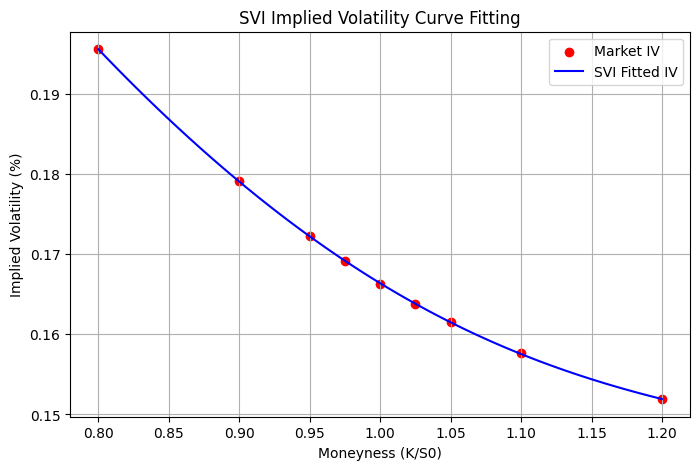

In [ ]:
# EU50 Vols
moneyness = np.array([0.8, 0.9, 0.95, 0.975, 1.0, 1.025, 1.05, 1.1, 1.2])
implied_vols = np.array([19.55, 17.91, 17.22, 16.91, 16.63, 16.38, 16.15, 15.76, 15.19])/100

# Optimization
init_params = [0, 0.2]  # m, sigma

# SVI 2steps
svi_params = svi_2steps(implied_vols, np.log(moneyness), init_params, maxiter=10, exit_tol=1e-12, verbose=True)

a_svi, d_svi, c_svi, m_svi, sigma_svi, _ = svi_params
print(f"Optimized SVI Parameters: a={a_svi}, d={d_svi}, c={c_svi}, m={m_svi}, sigma={sigma_svi}")

# Fit vol curve
moneyness_grid = np.linspace(0.8, 1.2, 100)
fitted_iv = cal_iv(np.log(moneyness_grid), svi_params)

# Draw IV surface
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(moneyness, implied_vols, color='red', label="Market IV", marker='o')  # True IV
plt.plot(moneyness_grid, fitted_iv, label="SVI Fitted IV", linestyle='-', color='blue')  # SVI fitted IV
plt.xlabel("Moneyness (K/S0)")
plt.ylabel("Implied Volatility (%)")
plt.title("SVI Implied Volatility Curve Fitting")
plt.legend()
plt.grid()
plt.show()



In [ ]:
from scipy.interpolate import interp1d


interp_iv = interp1d(moneyness_grid, fitted_iv, kind='cubic', fill_value="extrapolate")

In [ ]:
interp_iv(1/1.64)

array(0.23731903)

In [ ]:
# Parameters
S0 = 4833.53  # Stock price in EUR
T = 5     # Time to maturity (5 years)
r = (3.88525+3.92810)/2/100  # USD risk-free rate
rf = (2.06081+2.07379)/2/100 # EUR risk-free rate
sigma_e = (7.7+8.745)/2/100  # FX volatility
rho = 0.390  # Correlation between stock and FX rate

# d = 2.8323/100  # Dividend yield
# fx0 = 1.053 #EU-USD FX at T=0

d = 3.1413/100 # Dividend yield
fx0 = 1 #EU-USD FX at T=0

# Compute Quanto Option Prices
# [-100,-15]
put_payoff_1_price = black_scholes_quanto(S0, 0.85 * S0, T, r, rf, d, interp_iv(1/0.85), sigma_e, rho, fx0, "put")
digital_put_1_price = digital_quanto(S0, 0.85 * S0, T, r, rf, d, interp_iv(1/0.85), sigma_e, rho, fx0, "put")

# [-15,0]
digital_call_2_price = digital_quanto(S0, 0.85 * S0, T, r, rf, d, interp_iv(1/0.85), sigma_e, rho, fx0, "call")
call_payoff_1_price = black_scholes_quanto(S0, 0.85 * S0, T, r, rf, d, interp_iv(1/0.85), sigma_e, rho, fx0, "call")
call_payoff_2_price = black_scholes_quanto(S0, S0, T, r, rf, d, interp_iv(1.0), sigma_e, rho, fx0, "call")

# [0,64]
digital_call_3_price = digital_quanto(S0, S0, T, r, rf, d, interp_iv(1.0), sigma_e, rho, fx0, "call")

# [64,]
call_payoff_3_price = black_scholes_quanto(S0, 1.64 * S0, T, r, rf, d, interp_iv(1/1.64), sigma_e, rho, fx0, "call")

# Compute Portfolio Price
Portfolio_price = 1000/S0 * (-put_payoff_1_price - digital_put_1_price * 0.15 * S0 - call_payoff_1_price +
                              digital_call_2_price * 0.15 * S0 + call_payoff_2_price +
                              digital_call_3_price * 0.64 * S0 + call_payoff_3_price ) + 1000 * np.exp(-r*T)

# answer is 953.10
Portfolio_price


929.7869213799621

# Sensitive Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sigma_e_values = np.linspace(0.05, 0.15, 10)  # 5% - 15%
dividend_values = np.linspace(0.02, 0.05, 10)  # 2% - 5%

Sigma_E, Dividend = np.meshgrid(sigma_e_values, dividend_values)
Portfolio_Price_Surface = np.zeros_like(Sigma_E)

for i in range(Sigma_E.shape[0]):
    for j in range(Sigma_E.shape[1]):
        sigma_e = Sigma_E[i, j]
        d = Dividend[i, j]

        put_payoff_1_price = black_scholes_quanto(S0, 0.85 * S0, T, r, rf, d, interp_iv(1/0.85), sigma_e, rho, fx0, "put")
        digital_put_1_price = digital_quanto(S0, 0.85 * S0, T, r, rf, d, interp_iv(1/0.85), sigma_e, rho, fx0, "put")
        digital_call_2_price = digital_quanto(S0, 0.85 * S0, T, r, rf, d, interp_iv(1/0.85), sigma_e, rho, fx0, "call")
        call_payoff_1_price = black_scholes_quanto(S0, 0.85 * S0, T, r, rf, d, interp_iv(1/0.85), sigma_e, rho, fx0, "call")
        call_payoff_2_price = black_scholes_quanto(S0, S0, T, r, rf, d, interp_iv(1.0), sigma_e, rho, fx0, "call")
        digital_call_3_price = digital_quanto(S0, S0, T, r, rf, d, interp_iv(1.0), sigma_e, rho, fx0, "call")
        call_payoff_3_price = black_scholes_quanto(S0, 1.64 * S0, T, r, rf, d, interp_iv(1/1.64), sigma_e, rho, fx0, "call")

        Portfolio_Price_Surface[i, j] = 1000/S0 * (-put_payoff_1_price - digital_put_1_price * 0.15 * S0 - call_payoff_1_price +
                                                   digital_call_2_price * 0.15 * S0 + call_payoff_2_price +
                                                   digital_call_3_price * 0.64 * S0 + call_payoff_3_price ) + 1000 * np.exp(-r*T)

price_table = pd.DataFrame(Portfolio_Price_Surface, index=np.round(dividend_values, 4), columns=np.round(sigma_e_values, 4))
price_table.index.name = 'Dividend Yield'
price_table.columns.name = 'FX Volatility'
price_table


FX Volatility,0.0500,0.0611,0.0722,0.0833,0.0944,0.1056,0.1167,0.1278,0.1389,0.1500
Dividend Yield,,,,,,,,,,
0.0200,999.000393,993.519092,988.062585,982.630797,977.223655,971.841093,966.483049,961.149466,955.840292,950.555479
0.0233,980.675902,975.242931,969.835101,964.452348,959.094614,953.761846,948.453995,943.171014,937.912863,932.679503
0.0267,962.409232,957.027525,951.671344,946.340638,941.035360,935.755467,930.500918,925.271679,920.067716,914.889001
0.0300,944.215709,938.888323,933.586879,928.311336,923.061655,917.837803,912.639747,907.467458,902.320911,897.200082
0.0333,926.111062,920.841140,915.597599,910.380406,905.189529,900.024939,894.886610,889.774518,884.688640,879.628959
0.0367,908.111292,902.902034,897.719610,892.563992,887.435153,882.333067,877.257712,872.209066,867.187109,862.191824
0.0400,890.232548,885.087176,879.969097,874.878285,869.814714,864.778363,859.769208,854.787230,849.832408,844.904725
0.0433,872.491000,867.412725,862.362199,857.339396,852.344292,847.376862,842.437084,837.524936,832.640397,827.783446
0.0467,854.902714,849.894706,844.914891,839.963242,835.039734,830.144339,825.277033,820.437790,815.626586,810.843395


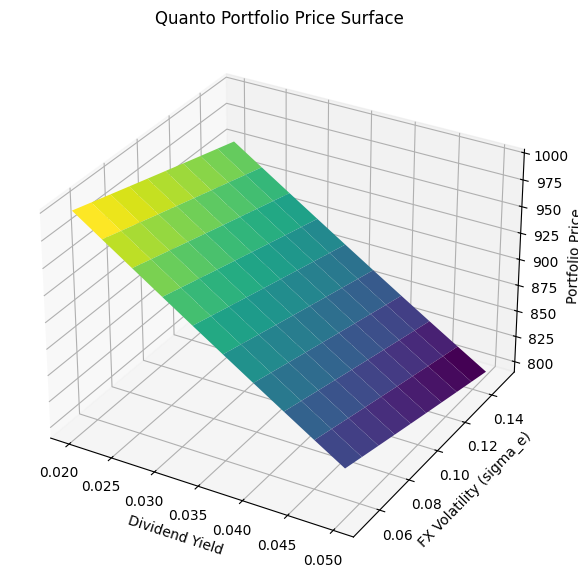

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Dividend,Sigma_E, Portfolio_Price_Surface, cmap='viridis')
ax.set_ylabel("FX Volatility (sigma_e)")
ax.set_xlabel("Dividend Yield")
ax.set_zlabel("Portfolio Price")
ax.set_title("Quanto Portfolio Price Surface")

plt.show()